In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def consolidate_cage(row, biotype_col):
    if row[biotype_col] == "reclassified - CAGE peak":
        return "no CAGE activity"
    else:
        return row[biotype_col]

In [5]:
def fix_cleaner_biotype(row, biotype_col):
    try:
        if row["name"] == "random_sequence":
            return "negative control"
        elif "samp" in row.element:
            return "positive control"
        else:
            return row[biotype_col]
    except:
        return row[biotype_col]

In [6]:
def is_sig(row, col):
    if row[col] < 0.05:
        return "sig"
    else:
        return "not sig"

In [7]:
def fix_cage_exp(row, col):
    if row[col] == "no cage activity":
        return 0
    else:
        return float(row[col])

## variables

In [8]:
data_dir = "../../../data/02__mpra/02__activs"
alpha_f = "%s/alpha_per_elem.quantification.txt" % data_dir

In [9]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [10]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.UPDATED_WITH_DIV.txt"

## 1. import files

In [11]:
alpha = pd.read_table(alpha_f, sep="\t")
alpha.reset_index(inplace=True)
alpha.head()

,index,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj
0,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...,7.295239,6.315911,2.825214e-75,1.383066e-42,4.596852e-74,1.878236e-41
1,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,1.326796,1.348824,1.451021e-01,2.326515e-01,3.319934e-01,5.455262e-01
2,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...,0.977164,1.548916,4.814953e-01,1.057092e-01,7.164347e-01,3.127558e-01
3,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...,0.976127,0.818171,4.826910e-01,7.414048e-01,7.167637e-01,8.145300e-01
4,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,1.323999,1.457128,1.469545e-01,1.559242e-01,3.356231e-01,4.172106e-01


In [12]:
index = pd.read_table(index_f, sep="\t")

In [13]:
index_elem = index[["element", "tile_type", "element_id", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [14]:
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,har,orig_species,lift_species,oligo_type,hg19_id,mm9_id,cleaner_biotype_hg19,cleaner_biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,False,human,mouse,human__divergent:mouse__divergent,h.2,m.1,div. lncRNA,div. lncRNA,lncRNA,lncRNA
1,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,False,human,mouse,human__divergent:mouse__antisense,h.3,m.2,div. lncRNA,other lncRNA,lncRNA,lncRNA
2,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,False,human,mouse,human__antisense:mouse__protein_coding,h.4,m.3,other lncRNA,mRNA,lncRNA,mRNA
3,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,False,human,mouse,human__intergenic:mouse__intergenic,h.5,m.4,lincRNA,other lncRNA,lncRNA,lncRNA
4,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,False,human,mouse,human__intergenic:mouse__intergenic,h.6,m.4,lincRNA,other lncRNA,lncRNA,lncRNA


In [15]:
tss_map["minimal_biotype_hg19"] = tss_map.apply(consolidate_cage, biotype_col="minimal_biotype_hg19", axis=1)
tss_map["minimal_biotype_mm9"] = tss_map.apply(consolidate_cage, biotype_col="minimal_biotype_mm9", axis=1)

## 2. merge alphas w/ index

In [16]:
pos_ctrls = alpha[alpha["index"].str.contains("__samp")]
pos_ctrls["HUES64_log"] = np.log10(pos_ctrls["HUES64"])
pos_ctrls["mESC_log"] = np.log10(pos_ctrls["mESC"])
len(pos_ctrls)

400

In [17]:
alpha = alpha[~alpha["index"].str.contains("__samp")]
len(alpha)

13479

In [18]:
data = alpha.merge(index_elem, left_on="index", right_on="element", how="left")
data.drop("index", axis=1, inplace=True)
data.head()

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info
0,7.295239,6.315911,2.825214e-75,1.383066e-42,4.596852e-74,1.878236e-41,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...,WILDTYPE,MOUSE_EVO_TSS__m.3163__tile1:53114165-53114309...,MOUSE_EVO_TSS__m.3163__tile1,1.0,chr11,-,53114165,53114309,8265.1.0.0
1,1.326796,1.348824,1.451021e-01,2.326515e-01,3.319934e-01,5.455262e-01,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...,WILDTYPE,HUMAN_EVO_TSS__h.1133__tile1:129255098-1292552...,HUMAN_EVO_TSS__h.1133__tile1,1.0,chrX,-,129255098,129255242,7281.1.0.0
2,0.977164,1.548916,4.814953e-01,1.057092e-01,7.164347e-01,3.127558e-01,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...,WILDTYPE,MOUSE_EVO_TSS__m.596__tile2:136753021-13675316...,MOUSE_EVO_TSS__m.596__tile2,1.0,chr6,-,136753021,136753165,12910.1.0.0
3,0.976127,0.818171,4.826910e-01,7.414048e-01,7.167637e-01,8.145300e-01,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...,WILDTYPE,MOUSE_EVO_TSS__m.2358__tile2:15536411-15536555...,MOUSE_EVO_TSS__m.2358__tile2,1.0,chr14,-,15536411,15536555,9294.1.0.0
4,1.323999,1.457128,1.469545e-01,1.559242e-01,3.356231e-01,4.172106e-01,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...,WILDTYPE,HUMAN_EVO_TSS__h.1436__tile1:157192113-1571922...,HUMAN_EVO_TSS__h.1436__tile1,1.0,chr2,+,157192113,157192257,4134.1.0.0


In [19]:
data["HUES64_log"] = np.log10(data["HUES64"])
data["mESC_log"] = np.log10(data["mESC"])
data.sample(5)

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,HUES64_log,mESC_log
5895,2.758273,2.120578,1.006826e-07,3.128699e-03,4.884214e-07,1.407104e-02,CTCACAAGCATCTGCAGACTGAAGCCTGACATCCAAGCTCCGGCTC...,WILDTYPE,MOUSE_EVO_TSS__m.265__tile1:101129073-10112921...,MOUSE_EVO_TSS__m.265__tile1,1.0,chr15,-,101129073,101129217,9730.1.0.0,0.440637,0.326454
10316,1.304056,1.356597,1.606228e-01,2.265295e-01,3.598522e-01,5.361532e-01,GTGTTGTTGCCTAGAGTTTGTCCCAGCGGAGGGTTGGCTTCGGATC...,WILDTYPE,HUMAN_EVO_TSS__h.508__tile2:232646166-23264631...,HUMAN_EVO_TSS__h.508__tile2,1.0,chr2,+,232646166,232646310,4323.1.0.0,0.115296,0.132451
4206,8.062662,6.370035,4.683018e-94,1.997345e-43,9.052313e-93,2.736540e-42,CCCAGAACCTGCGCGAGGGAGACGCCCCTCCTCTGGCCCCGCCCCA...,WILDTYPE,MOUSE_EVO_TSS__m.2627__tile2:59966640-59966784...,MOUSE_EVO_TSS__m.2627__tile2,1.0,chr8,+,59966640,59966784,13593.1.0.0,0.906478,0.804142
8727,0.495777,0.349600,9.108425e-01,9.688609e-01,9.214653e-01,9.706093e-01,GGACAGATGGATCGTCTGCGGTGCAGGTCACGGTACTCGTCAACAC...,RANDOM,random_sequence_270;270,random_sequence,0.0,NaN,NaN,0,0,none,-0.304714,-0.456428
6673,0.652276,1.256125,8.141533e-01,3.122605e-01,8.588305e-01,6.394014e-01,CTTGGATAATACAGACTACTGTCCGAGCGGCCGCGCACCCTTGTGT...,RANDOM,random_sequence_729;729,random_sequence,0.0,NaN,NaN,0,0,none,-0.185569,0.099033


## 3. compare activities across biotypes + controls

In [20]:
data["tss_id"] = data["name"].str.split("__", expand=True)[1]
data["species"] = data["name"].str.split("_", expand=True)[0]
data["tss_tile_num"] = data["name"].str.split("__", expand=True)[2]
data.sample(5)

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,...,chrom,strand,actual_start,actual_end,dupe_info,HUES64_log,mESC_log,tss_id,species,tss_tile_num
358,0.700698,1.319318,0.774350,0.256707,0.838138,0.576791,AACCTTAGTTGATGGCTGTCCAGCCGGCTGGTTCTTCCCTATTCAA...,WILDTYPE,HUMAN_EVO_TSS__h.2548__tile1:128446499-1284466...,HUMAN_EVO_TSS__h.2548__tile1,...,chr3,+,128446499,128446643,4984.1.0.0,-0.154469,0.120349,h.2548,HUMAN,tile1
727,1.081096,0.940521,0.364291,0.629301,0.623273,0.776341,AATCCCTCACCTTAAACACTGGCCTGCACCACCAAGAAAAGAGAAA...,WILDTYPE,HUMAN_EVO_TSS__h.2549__tile1:53293783-53293927...,HUMAN_EVO_TSS__h.2549__tile1,...,chr5,+,53293783,53293927,5559.1.0.0,0.033864,-0.026631,h.2549,HUMAN,tile1
11453,1.407988,2.023896,0.098090,0.006515,0.243322,0.027694,TCGAACATTCCACGTATCAACCCCACTAGCTAATGGGCCGGAATCT...,RANDOM,random_sequence_95;95,random_sequence,...,NaN,NaN,0,0,none,0.148599,0.306188,None,random,None
8967,0.865699,1.168591,0.608727,0.396594,0.777805,0.699274,GGCAGCAATGACTTGGTTGAAGCCAGAAACACGGCTCAGGGAGGGC...,WILDTYPE,MOUSE_EVO_TSS__m.1478__tile1:118164327-1181644...,MOUSE_EVO_TSS__m.1478__tile1,...,chr11,+,118164327,118164471,8690.1.0.0,-0.062633,0.067662,m.1478,MOUSE,tile1
12430,0.837084,1.088092,0.640115,0.478802,0.788397,0.735505,TGGTAAAAGTTCTCACTAATCCTCAATATTCCACTTTTTAAAATCT...,WILDTYPE,HUMAN_EVO_TSS__h.2883__tile2:26100209-26100353...,HUMAN_EVO_TSS__h.2883__tile2,...,chr2,+,26100209,26100353,3765.1.0.0,-0.077231,0.036666,h.2883,HUMAN,tile2


In [21]:
pos_ctrls.columns = ["element", "HUES64", "mESC", "HUES64_pval", "mESC_pval", "HUES64_padj", "mESC_padj", 
                     "HUES64_log", "mESC_log"]
pos_ctrls.head()

,element,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,HUES64_log,mESC_log
13479,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,10.585288,12.455913,7.760025e-171,1.851729e-192,2.740493e-169,8.711916e-191,1.024703,1.095376
13480,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,10.611084,13.552032,9.670958e-172,8.328827e-231,3.424062e-170,4.737533e-229,1.025760,1.132004
13481,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,9.462360,11.222268,8.292916e-134,1.671784e-153,2.200715e-132,5.919055e-152,0.975999,1.050081
13482,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,8.584887,9.679400,4.677367e-108,4.801421e-111,9.880849e-107,1.187859e-109,0.933735,0.985848
13483,AGTTCCGCTTACATAACTTACGGTAAATGGCCCGCCTGGCTGACCG...,7.873613,9.444499,3.126802e-89,3.430614e-105,5.809490e-88,8.237629e-104,0.896174,0.975179


In [22]:
human_df = data[(data["species"] == "HUMAN") | (data["name"] == "random_sequence")]
mouse_df = data[(data["species"] == "MOUSE") | (data["name"] == "random_sequence")]

human_df_w_ctrls = human_df.append(pos_ctrls)
mouse_df_w_ctrls = mouse_df.append(pos_ctrls)

human_df_w_ctrls = human_df_w_ctrls.merge(tss_map[["hg19_id", "biotype_hg19", "cleaner_biotype_hg19", 
                                                   "minimal_biotype_hg19", "stem_exp_hg19", 
                                                   "orig_species"]], 
                                          left_on="tss_id", right_on="hg19_id", how="left")
mouse_df_w_ctrls = mouse_df_w_ctrls.merge(tss_map[["mm9_id", "biotype_mm9", "cleaner_biotype_mm9", 
                                                   "minimal_biotype_mm9", "stem_exp_mm9", 
                                                   "orig_species"]], 
                                          left_on="tss_id", right_on="mm9_id", how="left")
mouse_df_w_ctrls.sample(5)

,HUES64,HUES64_log,HUES64_padj,HUES64_pval,actual_end,actual_start,chrom,dupe_info,element,element_id,...,tile_number,tile_type,tss_id,tss_tile_num,mm9_id,biotype_mm9,cleaner_biotype_mm9,minimal_biotype_mm9,stem_exp_mm9,orig_species
5654,2.982902,0.474639,1.309438e-08,2.490753e-09,22329162.0,22329018.0,chr10,7800.1.0.0,GCGGAATTCCCTCCAACTCGCTCAGGGATTGGCAAAACAAAAGCCA...,MOUSE_EVO_TSS__m.2273__tile1:22329018-22329162...,...,1.0,WILDTYPE,m.2273,tile1,m.2273,no cage activity,no CAGE activity,no CAGE activity,no cage activity,human
2572,0.859713,-0.065647,7.794620e-01,6.153591e-01,134219566.0,134219422.0,chr1,7561.1.0.0,CAGCTCTCTGGACAGCAGGCTCTTTTCGGTTTGTGCTCCCCATCTG...,MOUSE_EVO_TSS__m.1019__tile1:134219422-1342195...,...,1.0,WILDTYPE,m.1019,tile1,m.1019,enhancer,eRNA,eRNA,0.12205899999999999,human
429,0.418786,-0.378008,9.464546e-01,9.416353e-01,12432887.0,12432743.0,chr8,13493.1.0.0,AAGGCTGCTCATGAATTCGGGTCGTATAATTTTCAGAGTCTACATC...,MOUSE_EVO_TSS__m.1948__tile2:12432743-12432887...,...,1.0,WILDTYPE,m.1948,tile2,m.1948,no cage activity,no CAGE activity,no CAGE activity,no cage activity,human
6406,0.855025,-0.068021,7.810237e-01,6.205309e-01,56920642.0,56920498.0,chr9,13905.1.0.0,GGGCGCGCTCTGGGGAGGCGCGGGCACCGTGGGCCCGCGGTTGTTA...,MOUSE_EVO_TSS__m.1326__tile1:56920498-56920642...,...,1.0,WILDTYPE,m.1326,tile1,m.1326,enhancer,eRNA,eRNA,0.0922741,human
9184,1.385570,0.141628,2.662892e-01,1.097851e-01,0.0,0.0,NaN,none,TTTCAATCAGTCCCAAGGGCTATGTGTAATTTGGTCACTAGGCCAA...,random_sequence_1150;1150,...,0.0,RANDOM,None,None,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
human_df_w_ctrls["minimal_biotype_hg19"] = human_df_w_ctrls.apply(fix_cleaner_biotype, 
                                                                  biotype_col="minimal_biotype_hg19",
                                                                  axis=1)
human_df_w_ctrls.minimal_biotype_hg19.value_counts()

eRNA                2118
no CAGE activity    1649
lncRNA              1631
negative control    1618
mRNA                1110
positive control     400
other                 95
Name: minimal_biotype_hg19, dtype: int64

In [24]:
mouse_df_w_ctrls["minimal_biotype_mm9"] = mouse_df_w_ctrls.apply(fix_cleaner_biotype, 
                                                                 biotype_col="minimal_biotype_mm9",
                                                                 axis=1)
mouse_df_w_ctrls.minimal_biotype_mm9.value_counts()

eRNA                2321
no CAGE activity    1887
negative control    1618
mRNA                1243
lncRNA              1063
positive control     400
other                117
Name: minimal_biotype_mm9, dtype: int64

In [25]:
min_ctrl_order = ["negative control", "no CAGE activity", "eRNA", 
                  "lncRNA", "mRNA", "positive control"]

min_human_ctrl_pal = {"negative control": "lightgray", "no CAGE activity": "gray", "reclassified - CAGE peak": "gray",
                      "eRNA": sns.color_palette("Set2")[1], "lncRNA": sns.color_palette("Set2")[1], 
                      "mRNA": sns.color_palette("Set2")[1], "positive control": "black"}

min_mouse_ctrl_pal = {"negative control": "lightgray", "no CAGE activity": "gray", "reclassified - CAGE peak": "gray",
                      "eRNA": sns.color_palette("Set2")[0], "lncRNA": sns.color_palette("Set2")[0], 
                      "mRNA": sns.color_palette("Set2")[0],"positive control": "black"}

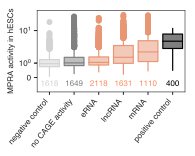

In [29]:
fig = plt.figure(figsize=(2.65, 1.5))
ax = sns.boxplot(data=human_df_w_ctrls, x="minimal_biotype_hg19", y="HUES64", flierprops = dict(marker='o', markersize=5),
                 order=min_ctrl_order, palette=min_human_ctrl_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(min_ctrl_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("MPRA activity in hESCs")

for i, label in enumerate(min_ctrl_order):
    n = len(human_df_w_ctrls[human_df_w_ctrls["minimal_biotype_hg19"] == label])
    color = min_human_ctrl_pal[label]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 60))
plt.show()
fig.savefig("better_neg_ctrl_boxplot.human.pdf", dpi="figure", bbox_inches="tight")
plt.close()

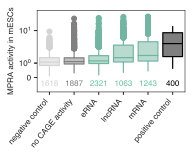

In [30]:
fig = plt.figure(figsize=(2.65, 1.5))
ax = sns.boxplot(data=mouse_df_w_ctrls, x="minimal_biotype_mm9", y="mESC", flierprops = dict(marker='o', markersize=5),
                 order=min_ctrl_order, palette=min_mouse_ctrl_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(min_ctrl_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("MPRA activity in mESCs")

for i, label in enumerate(min_ctrl_order):
    n = len(mouse_df_w_ctrls[mouse_df_w_ctrls["minimal_biotype_mm9"] == label])
    color = min_mouse_ctrl_pal[label]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 60))
plt.show()
fig.savefig("better_neg_ctrl_boxplot.mouse.pdf", dpi="figure", bbox_inches="tight")
plt.close()

## 4. compare activities across tiles

In [31]:
df = data[data["tss_tile_num"].isin(["tile1", "tile2"])]
human_df = df[df["species"] == "HUMAN"]
mouse_df = df[df["species"] == "MOUSE"]

human_df = human_df.merge(tss_map[["hg19_id", "biotype_hg19", "stem_exp_hg19", "orig_species"]], left_on="tss_id", 
                          right_on="hg19_id", how="right")
mouse_df = mouse_df.merge(tss_map[["mm9_id", "biotype_mm9", "stem_exp_mm9", "orig_species"]], left_on="tss_id", 
                          right_on="mm9_id", how="right")
mouse_df.sample(5)

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj,element,tile_type,element_id,name,...,dupe_info,HUES64_log,mESC_log,tss_id,species,tss_tile_num,mm9_id,biotype_mm9,stem_exp_mm9,orig_species
6351,0.956999,0.749012,0.504757,0.795952,0.729286,0.840142,TAGTTTCAGGAGTAGAAAGTCGGTTTTGCAGGCACTGAGTGGAGGG...,WILDTYPE,MOUSE_EVO_TSS__m.2237__tile2:20533082-20533226...,MOUSE_EVO_TSS__m.2237__tile2,...,8177.1.0.0,-0.019088,-0.125511,m.2237,MOUSE,tile2,m.2237,no cage activity,no cage activity,human
115,1.105946,1.140656,0.337649,0.424795,0.599517,0.712316,CCTGCCAGCCCCACCTGAGTTGGATGCAGCTGCACACTGCATGAGA...,WILDTYPE,MOUSE_EVO_TSS__m.1818__tile2:44059284-44059428...,MOUSE_EVO_TSS__m.1818__tile2,...,7379.1.0.0,0.043734,0.057155,m.1818,MOUSE,tile2,m.1818,no cage activity,no cage activity,human
2330,0.514200,0.741699,0.901938,0.801290,0.914858,0.843595,ATAGACAGATTTACAATTTGAAAGGAAAAAAAAGTTCTGTCAATAA...,WILDTYPE,MOUSE_EVO_TSS__m.2498__tile1:140175810-1401759...,MOUSE_EVO_TSS__m.2498__tile1,...,13415.1.0.0,-0.288868,-0.129773,m.2498,MOUSE,tile1,m.2498,antisense,0.63875,mouse
2023,2.154757,1.176268,0.000278,0.388931,0.001070,0.694511,AGGGCCGGCAGAGTTCCGCCCCGCCCCACCCCACCCCCGCTTGTCC...,WILDTYPE,MOUSE_EVO_TSS__m.1040__tile2:53608306-53608450...,MOUSE_EVO_TSS__m.1040__tile2,...,8271.1.0.0,0.333398,0.070506,m.1040,MOUSE,tile2,m.1040,enhancer,0.170673,human
3734,1.163294,0.806032,0.279353,0.751494,0.533969,0.818758,CCCTGCTGCCGGGTCAACAGCGCTCTCTTTGTGTGTGAAGGATGGC...,WILDTYPE,MOUSE_EVO_TSS__m.2489__tile1:149955724-1499558...,MOUSE_EVO_TSS__m.2489__tile1,...,12540.1.0.0,0.065690,-0.093648,m.2489,MOUSE,tile1,m.2489,antisense,0.03,mouse


4.40059963736e-67
1.05539657309e-62


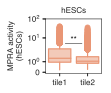

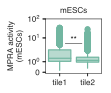

In [32]:
for df, species, colname, color in zip([human_df, mouse_df], ["hESCs", "mESCs"], ["HUES64", "mESC"], [sns.color_palette("Set2")[1], sns.color_palette("Set2")[0]]):
    fig = plt.figure(figsize=(1, 1))
    ax = sns.boxplot(data=df, x="tss_tile_num", y=colname, flierprops = dict(marker='o', markersize=5),
                     color=color)
    mimic_r_boxplot(ax)

    # calc p-vals b/w dists
    tile1_dist = np.asarray(df[df["tss_tile_num"] == "tile1"][colname])
    tile2_dist = np.asarray(df[df["tss_tile_num"] == "tile2"][colname])

    tile1_dist = tile1_dist[~np.isnan(tile1_dist)]
    tile2_dist = tile2_dist[~np.isnan(tile2_dist)]

    tile_u, tile_pval = stats.mannwhitneyu(tile1_dist, tile2_dist, alternative="two-sided", use_continuity=False)
    print(tile_pval)

    annotate_pval(ax, 0.2, 0.8, 5, 0, 5, tile_pval, fontsize)
    ax.set_yscale('symlog')
    ax.set_ylabel("MPRA activity\n(%s)" % species)
    ax.set_xlabel("")
    ax.set_title(species)
    ax.set_ylim((-0.1, 100))

## 5. correlate MPRA activities w/ endogenous activs

In [33]:
human_tmp = human_df_w_ctrls

In [34]:
human_tmp["stem_exp_hg19_fixed"] = human_tmp.apply(fix_cage_exp, col="stem_exp_hg19", axis=1)
human_tmp.sample(5)

,HUES64,HUES64_log,HUES64_padj,HUES64_pval,actual_end,actual_start,chrom,dupe_info,element,element_id,...,tile_type,tss_id,tss_tile_num,hg19_id,biotype_hg19,cleaner_biotype_hg19,minimal_biotype_hg19,stem_exp_hg19,orig_species,stem_exp_hg19_fixed
6600,0.798223,-0.097876,0.801925,0.681239,128807626.0,128807482.0,chr8,6778.1.0.0,GGTGCTCCTAAACCCTCATCATGGTCATTCTTCTTGGCTGGGCTGT...,HUMAN_EVO_TSS__h.2143__tile1:128807482-1288076...,...,WILDTYPE,h.2143,tile1,h.2143,intergenic,lincRNA,lncRNA,0.216667,human,0.216667
1877,1.434993,0.156850,0.216136,0.085246,63581435.0,63581291.0,chr11,1251.1.0.0,ATGGAGGGGATTCCACTTCCGCGTCACGGTGCGGGGCCGGGGCTGG...,HUMAN_EVO_TSS__h.2983__tile2:63581291-63581435...,...,WILDTYPE,h.2983,tile2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6532,1.506365,0.177930,0.154636,0.057391,32457075.0,32456931.0,chr11,1177.1.0.0,GGTAAGGAGTTCAAGGCAGCGCCCACACCCGGGGGCTCTCCGCAAC...,"HUMAN_EVO_TSS__h.913__tile2:32456931-32457075,...",...,WILDTYPE,h.913,tile2,h.913,div_pc,div. mRNA,mRNA,0.0,human,0.000000
151,1.364017,0.134820,0.289752,0.121943,27484381.0,27484237.0,chr12,1575.1.0.0,AAAGTAAAGCTCCAGAGCATAAAGAAAAAAAGAGAGCAAGCAGGCT...,HUMAN_EVO_TSS__h.1485__tile2:27484237-27484381...,...,WILDTYPE,h.1485,tile2,h.1485,enhancer,eRNA,eRNA,0.0558899,human,0.055890
1908,1.229954,0.089889,0.453182,0.218412,50788293.0,50788149.0,chr6,6018.1.0.0,ATGTAGGAGAGAGGAGGAGGAGATAAGAGAGGAGAGGGAGAAAAGC...,HUMAN_EVO_TSS__h.2555__tile1:50788149-50788293...,...,WILDTYPE,h.2555,tile1,h.2555,enhancer,eRNA,eRNA,0.0287066,human,0.028707


2909


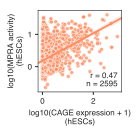

3019


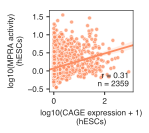

In [35]:
for tile_num in ["tile1", "tile2"]:
    df = human_tmp[(human_tmp["tss_tile_num"] == tile_num) & 
                   (~human_tmp["cleaner_biotype_hg19"].isin(["no CAGE activity", "reclassified - CAGE peak"]))]
    
    fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

    df["stem_exp_hg19_log"] = np.log10(df["stem_exp_hg19_fixed"] + 1)
    sub = df[~pd.isnull(df["HUES64_log"])]
    print(len(sub))

    sns.regplot(data=sub, x="stem_exp_hg19_log", y="HUES64_log", color=min_human_ctrl_pal["mRNA"], 
                scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, fit_reg=True, ax=ax)

    # annotate corr
    no_nan = sub[(~pd.isnull(sub["stem_exp_hg19_log"])) & (~pd.isnull(sub["HUES64_log"]))]
    r, p = spearmanr(no_nan["stem_exp_hg19_log"], no_nan["HUES64_log"])

    ax.text(0.95, 0.15, "r = {:.2f}".format(r), ha="right", va="bottom", fontsize=fontsize,
        transform=ax.transAxes)
    ax.text(0.95, 0.05, "n = %s" % (len(no_nan)), ha="right", va="bottom", fontsize=fontsize,
            transform=ax.transAxes)

    ax.set_xlabel("log10(CAGE expression + 1)\n(hESCs)")
    ax.set_ylabel("log10(MPRA activity)\n(hESCs)")

    plt.show()
    #fig.savefig("cage_corr_human.all.%s.pdf" % tile_num, dpi="figure", bbox_inches="tight")
    plt.close()

In [36]:
mouse_tmp = mouse_df_w_ctrls
mouse_tmp["stem_exp_mm9_fixed"] = mouse_tmp.apply(fix_cage_exp, col="stem_exp_mm9", axis=1)
len(mouse_tmp)

9743

2881


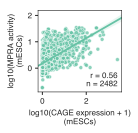

2957


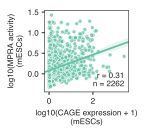

In [37]:
for tile_num in ["tile1", "tile2"]:
    df = mouse_tmp[(mouse_tmp["tss_tile_num"] == tile_num) & 
                   (~mouse_tmp["cleaner_biotype_mm9"].isin(["no CAGE activity", "reclassified - CAGE peak"]))]
    
    fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

    df["stem_exp_mm9_log"] = np.log10(df["stem_exp_mm9_fixed"] + 1)
    sub = df[~pd.isnull(df["mESC_log"])]
    print(len(sub))

    sns.regplot(data=sub, x="stem_exp_mm9_log", y="mESC_log", color=min_mouse_ctrl_pal["mRNA"], 
                scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, fit_reg=True, ax=ax)

    # annotate corr
    no_nan = sub[(~pd.isnull(sub["stem_exp_mm9_log"])) & (~pd.isnull(sub["mESC_log"]))]
    r, p = spearmanr(no_nan["stem_exp_mm9_log"], no_nan["mESC_log"])

    ax.text(0.95, 0.15, "r = {:.2f}".format(r), ha="right", va="bottom", fontsize=fontsize,
        transform=ax.transAxes)
    ax.text(0.95, 0.05, "n = %s" % (len(no_nan)), ha="right", va="bottom", fontsize=fontsize,
            transform=ax.transAxes)

    ax.set_xlabel("log10(CAGE expression + 1)\n(mESCs)")
    ax.set_ylabel("log10(MPRA activity)\n(mESCs)")

    plt.show()
#     fig.savefig("cage_corr_mouse.all.%s.pdf" % tile_num, dpi="figure", bbox_inches="tight")
    plt.close()

## 6. how does endogenous CAGE expr compare between human and mouse

In [38]:
human_tmp["species"] = "human"
mouse_tmp["species"] = "mouse"

human_tmp = human_tmp[["tss_id", "cleaner_biotype_hg19", "minimal_biotype_hg19", "stem_exp_hg19_fixed", "species"]]
human_tmp.columns = ["tss_id", "cleaner_biotype", "minimal_biotype", "stem_exp_fixed", "species"]
mouse_tmp = mouse_tmp[["tss_id", "cleaner_biotype_mm9", "minimal_biotype_mm9", "stem_exp_mm9_fixed", "species"]]
mouse_tmp.columns = ["tss_id", "cleaner_biotype", "minimal_biotype", "stem_exp_fixed", "species"]

tmp = human_tmp.append(mouse_tmp)
tmp["log"] = np.log10(tmp["stem_exp_fixed"]+1)
tmp.head(5)

,tss_id,cleaner_biotype,minimal_biotype,stem_exp_fixed,species,log
0,h.1133,eRNA,eRNA,0.203060,human,0.080287
1,h.1133,eRNA,eRNA,0.203060,human,0.080287
2,h.1436,eRNA,eRNA,0.039044,human,0.016634
3,h.1436,eRNA,eRNA,0.039044,human,0.016634
4,h.1951,lincRNA,lncRNA,0.028889,human,0.012368


In [39]:
tmp_pal = {"human": sns.color_palette("Set2")[1], "mouse": sns.color_palette("Set2")[0]}

0.033336205128
3.17680050912e-08
0.00382022389974


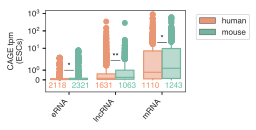

In [40]:
fig = plt.figure(figsize=(2.5, 1.5))

ax = sns.boxplot(data=tmp, x="minimal_biotype", y="stem_exp_fixed", hue="species",
                 flierprops = dict(marker='o', markersize=5),
                 order=["eRNA", "lncRNA", "mRNA"], palette=tmp_pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["eRNA", "lncRNA", "mRNA"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_yscale("symlog")
ax.set_ylabel("CAGE tpm\n(ESCs)")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

ys = [1, 2, 22]
for i, label in enumerate(["eRNA", "lncRNA", "mRNA"]):
    sub = tmp[tmp["minimal_biotype"] == label]
    human = sub[sub["species"] == "human"]
    mouse = sub[sub["species"] == "mouse"]
    
    human_vals = np.asarray(human["stem_exp_fixed"])
    mouse_vals = np.asarray(mouse["stem_exp_fixed"])

    human_vals = human_vals[~np.isnan(human_vals)]
    mouse_vals = mouse_vals[~np.isnan(mouse_vals)]

    u, pval = stats.mannwhitneyu(human_vals, mouse_vals, alternative="two-sided", use_continuity=False)
    print(pval)
    
    if pval >= 0.05:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize)
    else:
        annotate_pval(ax, i-0.1, i+0.1, ys[i], 0, ys[i], pval, fontsize)
    
    n_human = len(human)
    n_mouse = len(mouse)

    ax.annotate(str(n_human), xy=(i-0.25, -1), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=tmp_pal["human"], size=fontsize)
    ax.annotate(str(n_mouse), xy=(i+0.25, -1), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=tmp_pal["mouse"], size=fontsize)

ax.set_ylim((-1.25, 1500))
fig.savefig("human_v_mouse_cage.min.pdf", dpi="figure", bbox_inches="tight")

## 7. write files

In [41]:
human_df_filename = "%s/human_TSS_vals.both_tiles.txt" % data_dir
mouse_df_filename = "%s/mouse_TSS_vals.both_tiles.txt" % data_dir

In [42]:
human_df.to_csv(human_df_filename, sep="\t", index=False)
mouse_df.to_csv(mouse_df_filename, sep="\t", index=False)